# MODEL BUILDING

### Hans Schumann and Augie Doebling
### 27.April 2018 - 5.May 2018

Looking at building a model to show the probability of bitcoin increasing price over a given time.

In [2]:
"""
This file will take data from the SQL database and perform exploratory analysis for model building
"""

## import all packages / other files needed
import pymysql
import numpy as np
import pandas as pd
import helpers
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
## create credentials
DB_USERNAME = ""
DB_PASSWORD = ""
with open("creds.txt", "r") as creds:
    DB_USERNAME = creds.readline()[:-1]
    DB_PASSWORD = creds.readline()[:-1]

connection = pymysql.connect(host='seniorproject.cxbqypcd9gwp.us-east-2.rds.amazonaws.com',
                             user=DB_USERNAME,
                             password=DB_PASSWORD,
                             db='seniorproject')
## get all the rows from the sql database
cursor = connection.cursor()
sentimentQuery = "SELECT * FROM sentiment"
cursor.execute(sentimentQuery)
sentimentRows = cursor.fetchall()
## put all the rows in a dataframe
sentiment = pd.DataFrame(list(sentimentRows),
                         columns = ['key','id','datetime','currency','price','logprice',
                                    'times','count','favorites','retweets','avg_sentiment'])

## add day of the week variable
sentiment['datetime'] = pd.to_datetime(sentiment['datetime'])
sentiment['day_of_week'] = sentiment['datetime'].dt.weekday_name
sentiment = pd.concat([sentiment,pd.get_dummies(sentiment['day_of_week'])],axis = 1)

## convert necessary columns to numeric
sentiment['price'] = pd.to_numeric(sentiment['price'])
sentiment['logprice'] = pd.to_numeric(sentiment['logprice'])
sentiment['times'] = pd.to_numeric(sentiment['times'])
sentiment['count'] = pd.to_numeric(sentiment['count'])
sentiment['favorites'] = pd.to_numeric(sentiment['favorites'])
sentiment['retweets'] = pd.to_numeric(sentiment['retweets'])
sentiment['avg_sentiment'] = pd.to_numeric(sentiment['avg_sentiment'])

For this first model, we will look at the past data from a week prior.  Using this, we can develop a model to predict the probability of bitcoin increasing in price at a certain time in the future.

First we will set up the data and then divide it into a training and testing set

In [91]:
def create_rolling_sums(df,times):
    """
    Creates the training and testing sets with sums of the tweet variables
    for given time periods as specified
    :param df: the dataframe to use
    :param times: an array of the times wanted 
    :return dataframe with the created variables
    """
    for i in range(len(times)):
        df[('sum' + str(times[i]) + '_count')] = df['count'].rolling(times[i]-1).sum().fillna(method = 'bfill')
        df[('sum' + str(times[i]) + '_favorites')] = df['favorites'].rolling(times[i]-1).sum().fillna(method = 'bfill')
        df[('sum' + str(times[i]) + '_retweets')] = df['retweets'].rolling(times[i]-1).sum().fillna(method = 'bfill')
        df[('sum' + str(times[i]) + '_avg_sentiment')] = df['avg_sentiment'].rolling(times[i]-1).sum().fillna(method = 'bfill')
        # subtract all but the time period of interest
        if (i > 1):
            df[('sum' + str(times[i]) + '_count')] = df[('sum' + str(times[i]) + '_count')] - df['count'].rolling(times[i-1]-1).sum().fillna(method = 'bfill')
            df[('sum' + str(times[i]) + '_favorites')] = df[('sum' + str(times[i]) + '_favorites')] - df['favorites'].rolling(times[i-1]-1).sum().fillna(method = 'bfill')
            df[('sum' + str(times[i]) + '_retweets')] = df[('sum' + str(times[i]) + '_retweets')] - df['retweets'].rolling(times[i-1]-1).sum().fillna(method = 'bfill')
            df[('sum' + str(times[i]) + '_avg_sentiment')] = df[('sum' + str(times[i]) + '_avg_sentiment')] - df['avg_sentiment'].rolling(times[i-1]-1).sum().fillna(method = 'bfill')
    return df

In [94]:
dummy_df = helpers.create_rolling_sums(sentiment,[1440,2880,4320])

In [95]:
## create price changes for certain time periods in advance
dummy_df['price_change_1day'] = (dummy_df['price'].shift(-1440) - dummy_df['price']).fillna(method = 'ffill')
dummy_df['price_change_2days'] = (dummy_df['price'].shift(-2880) - dummy_df['price']).fillna(method = 'ffill')
dummy_df['price_change_3days'] = (dummy_df['price'].shift(-4320) - dummy_df['price']).fillna(method = 'ffill')

In [103]:
## divide into the training and testing set
x_vars = ['count','favorites','retweets','avg_sentiment',
          'sum1440_count','sum1440_favorites','sum1440_retweets','sum1440_avg_sentiment',
          'sum2880_count','sum2880_favorites','sum2880_retweets','sum2880_avg_sentiment',
          'sum4320_count','sum4320_favorites','sum4320_retweets','sum4320_avg_sentiment',
          'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_var = 'price_change_1day'

dummy_df = dummy_df.sample(frac = 1)
n = int(0.75 * len(dummy_df))
train = dummy_df[:n]
test = dummy_df[n:]
x_train = train[x_vars]
x_test = test[x_vars]

y_train = train[y_var]
y_test = test[y_var]

### Linear Model

In [48]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
lm.score(x_test, y_test)

0.12423591946233382

### KNN Regressor
For the price increase of Bitcoin in the next day.

In [104]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors = 101)
knn_reg.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=101, p=2,
          weights='uniform')

In [105]:
y_pred = knn_reg.predict(x_test)
knn_reg.score(x_test,y_test)

0.96804423515310678

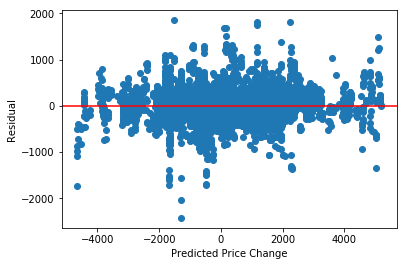

In [106]:
plt.plot(y_pred,y_test - y_pred,'o')
plt.ylabel('Residual')
plt.xlabel('Predicted Price Change')
plt.axhline(y = 0,color = 'red')

This may be an artifically enhanced model due to the random split of the training and testing set.  A more accurate way may be to use the first 70% to predict the final 30%.  This may have problems though due to the lack of extreme price changes until late.  
As of right now though, the KNN seems to be undoubtedly the most promising way to predict price changes in Bitcoin.

#### To avoid the similarity in price changes with points super close in time, we will only use one point per hour

In [118]:
dummy_df2 = helpers.create_rolling_sums(sentiment,[1440,2880,4320])

## create price changes for certain time periods in advance
dummy_df2['price_change_1day'] = (dummy_df2['price'].shift(-1440) - dummy_df2['price']).fillna(method = 'ffill')
dummy_df2['price_change_2days'] = (dummy_df2['price'].shift(-2880) - dummy_df2['price']).fillna(method = 'ffill')
dummy_df2['price_change_3days'] = (dummy_df2['price'].shift(-4320) - dummy_df2['price']).fillna(method = 'ffill')

dummy_df2 = dummy_df2[dummy_df['key']%60 == 0]

## divide into the training and testing set
x_vars = ['count','favorites','retweets','avg_sentiment',
          'sum1440_count','sum1440_favorites','sum1440_retweets','sum1440_avg_sentiment',
          'sum2880_count','sum2880_favorites','sum2880_retweets','sum2880_avg_sentiment',
          'sum4320_count','sum4320_favorites','sum4320_retweets','sum4320_avg_sentiment',
          'Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_var = 'price_change_1day'

dummy_df2 = dummy_df2.sample(frac = 1)
n = int(0.75 * len(dummy_df2))
train = dummy_df2[:n]
test = dummy_df2[n:]
x_train = train[x_vars]
x_test = test[x_vars]

y_train = train[y_var]
y_test = test[y_var]

C:\Users\Hans\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [119]:
knn_reg = KNeighborsRegressor(n_neighbors = 100)
knn_reg.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=100, p=2,
          weights='uniform')

In [122]:
knn_reg.score(x_test,y_test),np.mean(y_test)

(0.22908419723124529, 49.416924537009955)

### Testing different values for k

In [123]:
all_scores = []
for k in range(10,200,10):
    if k%100 == 0:
        print (k)
    knn_reg = KNeighborsRegressor(n_neighbors = k)
    knn_reg.fit(x_train,y_train)
    all_scores.append(knn_reg.score(x_test,y_test))

100


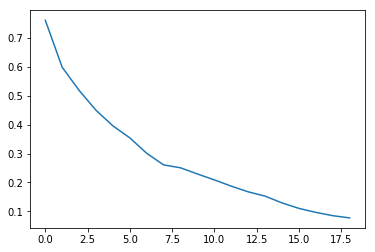

In [124]:
plt.plot(all_scores)

### trying only using first 70% of data
This didn't work because there was much less variability there

In [80]:
## divide into the training and testing set
dummy_df = helpers.create_rolling_sums(sentiment,[1440,2880,4320])

n = int(0.75 * len(dummy_df))
train = dummy_df2[:n]
test = dummy_df2[n:]
x_train = train[x_vars]
x_test = test[x_vars]

y_train = train[y_var]
y_test = test[y_var]

In [81]:
knn_reg = KNeighborsRegressor(n_neighbors = 101)
knn_reg.fit(x_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=101, p=2,
          weights='uniform')

In [82]:
knn_reg.score(x_test,y_test)

-0.020956475651527917

In [83]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(x_train,y_train > 0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

In [84]:
knn.score(x_test,y_test > 0)

0.53936103165753624

In [88]:
sentiment.iloc[309402]['datetime']

Timestamp('2017-09-12 08:17:00')

Training was very bad in this case.  This is due though to the ending of the 70% training set.  It ends in Spetember, well before the price really begins to spike and dip vigorously.  This may lead to the thought of the other training and testing being better, but we must use it with caution due to the possible faults of independence in the training data.

### Logistic Regression

In [50]:
from sklearn import linear_model
lm = linear_model.LogisticRegression()
lm.fit(x_train, y_train > 0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
lm.score(x_test, y_test > 0),np.mean(y_test > 0)

(0.61184854801958599, 0.61332234449992729)

### KNN Classifier
For whether or not Bitcoin increases price.

In [107]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 101)
knn.fit(x_train,y_train > 0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=101, p=2,
           weights='uniform')

In [108]:
knn.score(x_test,y_test > 0)

0.95526251999806078

### Convolutional NN

This will probably be the best, but I am unsure of how exactly it will work

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

In [30]:
model = Sequential()
model.add()